In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt 
import pandas as pd
import common as cm
import statistics
from statistics import mode
from collections import Counter
import sys, os

# Part 1: Information Gain

Important note: this exercise uses Pandas (for data manipulation and analysis) and Graphviz (for graph-drawing) libraries. 

This exercise consists of 3 parts. Complete the first part to get a mark of 3.0, the first two parts to get 4.0, complete all assignments to get 5.0. 

1.1 ) There are 10 objects (data) characterized with 5 binary attributes:

In [2]:
attributeNames = ["attr 1", "attr 2", "attr 3", "attr 4", "attr 5"]

data = pd.DataFrame(
    [
        [1, 0, 1, 1, 1],
        [1, 1, 0, 0, 1],
        [0, 1, 1, 1, 1],
        [1, 0, 1, 0, 1],
        [1, 0, 0, 1, 1],
        [0, 0, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 0, 0, 1, 1],
        [0, 1, 0, 0, 1],
        [0, 0, 0, 1, 1],
    ],
    columns=attributeNames,
)

1.2) Each object is assigned to either a class "0" or "1". The assignments are as follows (cl):

In [3]:
data["cl"] = [1, 1, 1, 0, 0, 1, 1, 1, 0, 0]

Hint: How one can read data (columns) in Pandas:

In [4]:
print(data["cl"])
print(list(data["cl"]))
print(set(data["cl"]))
print(data["attr 1"])

0    1
1    1
2    1
3    0
4    0
5    1
6    1
7    1
8    0
9    0
Name: cl, dtype: int64
[1, 1, 1, 0, 0, 1, 1, 1, 0, 0]
{0, 1}
0    1
1    1
2    0
3    1
4    1
5    0
6    1
7    1
8    0
9    0
Name: attr 1, dtype: int64


Hint: How split data (Pandas DataFrame) base on column:

In [5]:
data[data['cl']==0]

,attr 1,attr 2,attr 3,attr 4,attr 5,cl
3,1,0,1,0,1,0
4,1,0,0,1,1,0
8,0,1,0,0,1,0
9,0,0,0,1,1,0


Hint: How take values from column (Pandas Series):

In [6]:
for id, row in data['cl'].items():
    print(id,row)

0 1
1 1
2 1
3 0
4 0
5 1
6 1
7 1
8 0
9 0


1.3 )  Finish the below function for calculating entropy. $H(CL) = - \sum_{y \in CL}p(y)log_2p(y)$ It should return a value of entropy for an input vector CL. Assume that $log_2(0)$ is equal to 0.

In [7]:
def getEntropy(cl):
    All = len(cl)
    P1, P0 = 0, 0
    for value in cl:
        if value == 1:
            P1 += 1
        elif value == 0:
            P0 += 1
    if P1 == 0:
        Ent = -((P0/All)*np.log2(P0/All))
    elif P0 == 0:
        Ent = -((P1/All)*np.log2(P1/All))
    else:
        Ent = -((P1/All)*np.log2(P1/All)) - ((P0/All)*np.log2(P0/All))
    return Ent

1.4 ) Calculate the entropy for the CL vector  (the result should be 0.97095...):

In [8]:
print(getEntropy(data['cl']))
print(getEntropy(data['attr 5']))

0.9709505944546686
-0.0


1.5) Finish the below function for calculating a conditional entropy: $H(CL|X) = - \sum_{x \in X} \sum_{y \in CL} p(x,y) log_2 \frac{p(x,y)}{p(x)}$. Assume that $log_2(0)$ is equal to 0 and if $p(x) = 0$, $\frac{p(x,y)}{p(x)}$ is equal to 0 as well.

In [9]:
def getConditionalEntropy(cl, attr):
    P0 = cl[attr == 0]
    P1 = cl[attr == 1]
    All = len(cl)
    temp1 = len(cl[attr == 1])
    temp0 = len(cl[attr == 0])
    if len(P0) == 0:
        Cond = (temp1/All)*getEntropy(P1)
    elif len(P1) == 0:
        Cond = (temp0/All)*getEntropy(P0)
    else:
        Cond = (temp1/All)*getEntropy(P1) + (temp0/All)*getEntropy(P0)
    return Cond

1.6 ) Calculate conditional entropies for given attribiutes.

In [10]:
print(getConditionalEntropy(data["cl"], data["attr 1"]))
print(getConditionalEntropy(data["cl"], data["attr 5"])) 

0.9509775004326937
0.9709505944546686


1.7 ) **Question: Which entropy is lesser and why?**

The one got with attribute 1, because it results in a better divided tree than attribute 5

1.8) Finish the below function for calculating information gain (use getEntropy() and getConditionalEntropy() functions):

In [11]:
def getInformationGain(cl, attr):
    Gain = getEntropy(cl) - getConditionalEntropy(cl, attr)
    return Gain

In [12]:
print(getInformationGain(data["cl"], data["attr 1"]))
print(getInformationGain(data["cl"], data["attr 5"]))

0.01997309402197489
0.0


1.9) **Question: Which IG is lesser and why?**

One with attribute 5, because every data has this attirbute so choosing to split on this argument will not give us any new information

# Part 2: ID3 algorithm

Decision tree consists of decision nodes and leaves. Nodes split data while leaves classify objects. Consider the class "Node" provided below. It consists of 4 fields:
- attr - attribute ID (use the names in attributeNames vector)
- left - left branch, i.e., a reference to other node
- right - right branch, i.e., a reference to other node
- value - a decision. If node = None, then the node is not a leaf. If value is not None, then a node is considered a leaf. 

Method __call__ returns the decision if the node is a leaf (i.e., when value is not None). 
Otherwise, it calls either the left or the right branch of an input object, based on the attribute value (0 -> left children; 1 -> right children). In this way, we can traverse the decision tree in order to find the final decision.

In [13]:
class Node:
    def __init__(self, attr, left, right, value):
        self.attr = attr
        self.left = left
        self.right = right
        self.value = value

    def __call__(self, obj):
        if self.value is None:
            if obj[self.attr] == 0:
                return self.left(obj)
            else:
                return self.right(obj)
        else:
            return self.value
        
### EXAMPLE
def example(obj):
    root = Node(0, None, None, None) ###  IN ROOT SPLIT ON 1ST (0) ATTRIBUTE
    lChildren = Node(1, None, None, None) ### IN ROOT's LEFT CHILDREN SPLIT ON 2ND (1) ATTRIBUTE
    rChildren = Node(None, None, None, 2) ### IN ROOT's RIGHT CHILDREN -> DECISION = 2
    root.left = lChildren
    root.right = rChildren
    llChildren = Node(None, None, None, 3) ### IN ROOT's LEFT-LEFT CHILDREN -> DECISION = 3
    lrChildren = Node(None, None, None, 4) ### IN ROOT's LEFT-RIGHT CHILDREN -> DECISION = 4
    lChildren.left = llChildren
    lChildren.right = lrChildren
    print(root(obj))
    
example([0, 0]) ### ROOT : FIRST ATTRIBUTE = 0 SO WE GO TO LEFT CHILDREN.
### IT IS A LEAF WITH THE DECISION = 3
### THEN, IN THE CORRESPONDING CHILDREN, THE SECOND ATTRIBUTE = 0, SO WE GO TO LEFT-LEFT CHILDREN

example([0, 1]) 
example([1, 0])
example([1, 1])

3
4
2
2


2.1) Create an initial root. Set the value (decision) to 1. 

In [14]:
root = Node(None, None, None, 1)

2.2) Use a getErrorRate method in common.py auxiliary file to calculate the error rate. The decision is made based on the majority rule. In case of tie, the method takes 0 as the default class.

In [15]:
cm.getErrorRate(root, data)

0.4

2.3) Use printGraph method (see the common.py file) to draw the decision tree and save it in a png file.

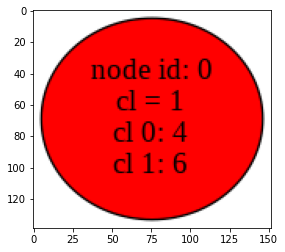

In [16]:
cm.printGraph(root, data, fileName = 'DecTree0')
plt.imshow(plt.imread('DecTree0.png'))

2.4) Calculate information gain for all attribiutes.

In [44]:
def printInformationGain(data , names):
    for attribute_name in names:
        temp1 = getInformationGain(data['cl'], data[attribute_name])
        print(str(temp1) + ' ' + str(attribute_name))
def getBestInformationGain(data, names):
    best = 0
    mem = None
    for attribute_name in names:
        temp1 = (getInformationGain(data['cl'], data[attribute_name]))
        if temp1 > best:
          best = temp1
          mem = attribute_name
        else:
          continue
    if mem is None:
      return "No split will provide new information"       

    #elif best < 'prepruning factor':         # PREPRUNING /OPTIONAL/
   #  return "No split should be performed"
    else:
      return mem
def Most_common(Class):
      temp1 = Counter(Class)
      return temp1.most_common(1)[0][0]

printInformationGain(data, attributeNames)
getBestInformationGain(data, attributeNames)

0.01997309402197489 attr 1
0.0464393446710154 attr 2
0.12451124978365313 attr 3
0.0912774462416801 attr 4
0.0 attr 5


'attr 3'

2.5) Choose the best attribute to split the data (HINT, it should be the third attribute :)). Construct two new nodes: one for $x_i$ = 0 decision and the second for $x_i$ = 1; connect them with the root (left and right branch). Remember to update the root. 

In [18]:
chosen0 = getBestInformationGain(data, attributeNames)
root.attr = chosen0
root.value = None
L1Child = Node(None, None, None, Most_common(data[data[chosen0]==0]['cl']))
R1Child = Node(None, None, None, Most_common(data[data[chosen0]==1]['cl']))
root.left = L1Child
root.right = R1Child

2.6) Print the graph and calculate the error rate. What happened with the error rate?

0.30000000000000004

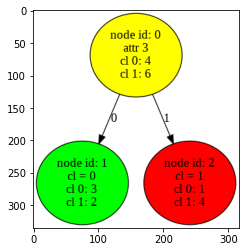

In [19]:
cm.printGraph(root, data, fileName = 'DecTree1')
plt.imshow(plt.imread('DecTree1.png'))
cm.getErrorRate(root, data)

The error rate decreased compared to w/o splitting

2.7) Split the 'data' (table) based on the selected attribiute, i.e., create two new tables.

In [20]:
left_data = data[data[chosen0]==0]
right_data = data[data[chosen0]==1]
print(left_data)
print('\n')
print(right_data)

   attr 1  attr 2  attr 3  attr 4  attr 5  cl
1       1       1       0       0       1   1
4       1       0       0       1       1   0
7       1       0       0       1       1   1
8       0       1       0       0       1   0
9       0       0       0       1       1   0


   attr 1  attr 2  attr 3  attr 4  attr 5  cl
0       1       0       1       1       1   1
2       0       1       1       1       1   1
3       1       0       1       0       1   0
5       0       0       1       1       1   1
6       1       1       1       1       1   1


2.8) Let us start with the left node. Firstly, calculate information gain for this node.

In [21]:
print(left_data)
printInformationGain(left_data, attributeNames)
getBestInformationGain(left_data, attributeNames)


   attr 1  attr 2  attr 3  attr 4  attr 5  cl
1       1       1       0       0       1   1
4       1       0       0       1       1   0
7       1       0       0       1       1   1
8       0       1       0       0       1   0
9       0       0       0       1       1   0
0.4199730940219749 attr 1
0.01997309402197489 attr 2
0.0 attr 3
0.01997309402197489 attr 4
0.0 attr 5


'attr 1'

2.9) Choose the best attribute to split the data and then update the decision tree.

In [22]:
chosen1 = getBestInformationGain(left_data, attributeNames)
L1Child.attr = chosen1
L1Child.value = None
L2Child = Node(None, None, None, Most_common(left_data[left_data[chosen1]==0]['cl']))
L1R1Child = Node(None, None, None, Most_common(left_data[left_data[chosen1]==1]['cl']))
L1Child.left = L2Child
L1Child.right = L1R1Child

2.10) Print the graph and calculate the error rate (HINT: should be 0.2 :). What happened with the error rate?

Error rate once again decreased

0.19999999999999996

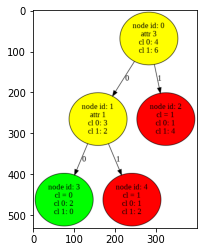

In [23]:
cm.printGraph(root, data, fileName = 'DecTree2')
plt.imshow(plt.imread('DecTree2.png'))
cm.getErrorRate(root, data)

2.11) Split data (remember that we split left_data, not data).

In [24]:
left_left_data = left_data[left_data[chosen1]==0]
right_left_data = left_data[left_data[chosen1]==1]
print(left_left_data)
print(right_left_data)

   attr 1  attr 2  attr 3  attr 4  attr 5  cl
8       0       1       0       0       1   0
9       0       0       0       1       1   0
   attr 1  attr 2  attr 3  attr 4  attr 5  cl
1       1       1       0       0       1   1
4       1       0       0       1       1   0
7       1       0       0       1       1   1


2.12) Repeat the whole process for the right node.

In [25]:
print(right_data)
printInformationGain(right_data, attributeNames)
getBestInformationGain(right_data, attributeNames)

   attr 1  attr 2  attr 3  attr 4  attr 5  cl
0       1       0       1       1       1   1
2       0       1       1       1       1   1
3       1       0       1       0       1   0
5       0       0       1       1       1   1
6       1       1       1       1       1   1
0.17095059445466865 attr 1
0.17095059445466865 attr 2
0.0 attr 3
0.7219280948873623 attr 4
0.0 attr 5


'attr 4'

In [26]:
chosen2 = getBestInformationGain(right_data, attributeNames)
R1Child.attr = chosen2
R1Child.value = None
R2Child = Node(None, None, None, Most_common(right_data[right_data[chosen2]==1]['cl']))
R1L1Child = Node(None, None, None, Most_common(right_data[right_data[chosen2]==0]['cl']))
R1Child.right = R2Child
R1Child.left = R1L1Child

0.09999999999999998

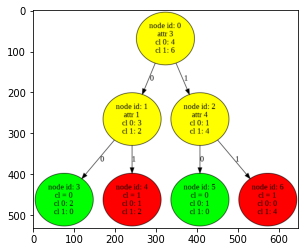

In [27]:
cm.printGraph(root, data, fileName = 'DecTree3')
plt.imshow(plt.imread('DecTree3.png'))
cm.getErrorRate(root, data)

In [28]:
left_right_data = right_data[right_data[chosen2]==0]
right_right_data = right_data[right_data[chosen2]==1]
print(left_right_data)
print(right_right_data)

   attr 1  attr 2  attr 3  attr 4  attr 5  cl
3       1       0       1       0       1   0
   attr 1  attr 2  attr 3  attr 4  attr 5  cl
0       1       0       1       1       1   1
2       0       1       1       1       1   1
5       0       0       1       1       1   1
6       1       1       1       1       1   1


2.13) Let's consider left-left node. Calculate information gain for it.

In [29]:
printInformationGain(left_left_data, attributeNames)
getBestInformationGain(left_left_data, attributeNames)

0.0 attr 1
0.0 attr 2
0.0 attr 3
0.0 attr 4
0.0 attr 5


'No split will provide new information'

2.14) Will adding a new node to the tree improve its effectiveness? Why? Why not?

No, because no matter on what atrribute we decide to split the left branch we will also get 1 error and all examples in the right branch are classified correctly

2.15) Calculate information gain for the left-right node.

In [30]:
printInformationGain(right_left_data, attributeNames)
getBestInformationGain(right_left_data, attributeNames)

0.0 attr 1
0.2516291673878229 attr 2
0.0 attr 3
0.2516291673878229 attr 4
0.0 attr 5


'attr 2'

In [31]:
chosen3 = getBestInformationGain(right_left_data, attributeNames)
L1R1Child.attr = chosen3
L1R1Child.value = None
L1R2Child = Node(None, None, None, Most_common(right_left_data[right_left_data[chosen3]==1]['cl']))
L1R1L1Child = Node(None, None, None, Most_common(right_left_data[right_left_data[chosen3]==0]['cl']))
L1R1Child.right = L1R2Child
L1R1Child.left = L1R1L1Child

0.09999999999999998

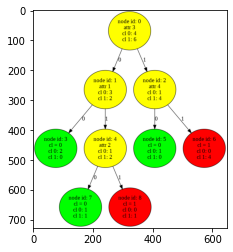

In [32]:
cm.printGraph(root, data, fileName = 'DecTree4')
plt.imshow(plt.imread('DecTree4.png'))
cm.getErrorRate(root, data)


2.16) What happened with the error rate? Is it necessary to keep these two newly added leaves?

It stayed the same. New leaves are redundant and not needed

2.17) Finish creating the right side of the tree

In [33]:
printInformationGain(left_right_data, attributeNames)
printInformationGain(right_right_data, attributeNames)

0.0 attr 1
0.0 attr 2
0.0 attr 3
0.0 attr 4
0.0 attr 5
0.0 attr 1
0.0 attr 2
0.0 attr 3
0.0 attr 4
0.0 attr 5


Splitting, creating new nodes/leaves does not provide any information gain so doing that is not needed so the right side of the tree is already finished.

# Part 3: automated construction of decision trees

3.1 Complete the following function for automated construct of decision trees, so that it returns a decision tree for the given data and attribute list. Note that this is a recusive method, i.e., calls itself.

In [47]:
from re import template
from ssl import DefaultVerifyPaths
from PIL.Image import NONE
depth = 0
def Naming(node, branch):
  node = str(node)
  new_node = node[:-4] + str(branch) + node[-4:]
  return new_node
  
name = 'root'
root = Node(None, None, None, Most_common(data['cl']))

def createTree(data, attributeNames, root, name, depth):
  if depth < max_depth:
    data = data.reset_index().drop("index", axis=1)
    chosen = getBestInformationGain(data, attributeNames)
    if chosen == 'No split will provide new information' or chosen == 'No split should be performed':
        #print("Split wasn't performed at " + str(name))  #Fun to see where the split doesnt happen,
                                                          #Although takes a lot of space in last exercise :C
        pass
    else:
        L_data = data[data[chosen]==0]
        R_data = data[data[chosen]==1]
        root.attr = chosen
        root.value = None
        tempL = Naming(name, 'L')
        tempR = Naming(name, 'R')
        Lnode = tempL
        Rnode = tempR
        Lnode = Node(None, None, None, Most_common(L_data['cl']))
        Rnode = Node(None, None, None, Most_common(R_data['cl']))
        root.left = Lnode
        root.right = Rnode

        depth += 1
        createTree(L_data, attributeNames, Lnode, tempL, depth)
        createTree(R_data, attributeNames, Rnode, tempR, depth)
  else:
    return 'Maximum depth exceeded'

3.2) Build a decision tree for a training dataset in the common.py auxiliary file, for diffrent values of max_depth.  Calculate & compare the error rates for training and validation datasets.

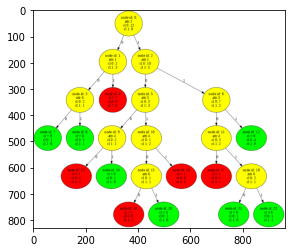

In [48]:
# Training dataset
max_depth = 10
depth = 0
train_attributeNames, train_data = cm.getTrainingDataSet()
root = Node(None, None, None, Most_common(train_data['cl']))
name = 'root'
TreeTest = createTree(train_data, train_attributeNames, root, name, depth)
cm.printGraph(root, train_data, fileName = 'TrainDecTree')
plt.imshow(plt.imread('TrainDecTree.png'))

In [49]:
# Validation dataset
max_depth = 10
valid_attributeNames, valid_data = cm.getValidationDataSet()
print(cm.getErrorRate(root, train_data))
print(cm.getErrorRate(root, valid_data))

0.19999999999999996
0.4


3.3) Consider only the training data set and answer the following questions:
* What is the miximum depth of the tree (consider only the training data set)?
* The tree building process should stop when there is no improvement in error rate (why?). Check for which value of "max_dept" there is no improvement in error rate. 

In [54]:
for i in range(10):
    max_depth = i
    depth = 0
    root = Node(None, None, None, Most_common(train_data['cl']))
    name = 'root'
    TreeValid = createTree(train_data, train_attributeNames, root, name, depth)
    print(cm.getErrorRate(root, valid_data), '| depth ' + str(i+1))

#for error in Errors:
  #print(error)

0.5 | depth 1
0.5 | depth 2
0.5 | depth 3
0.4 | depth 4
0.5 | depth 5
0.4 | depth 6
0.4 | depth 7
0.4 | depth 8
0.4 | depth 9
0.4 | depth 10
